# Podatki

Poniżej znajdują się uproszczone wyliczenia i wizualizacja efektywnej stawki podatkowej względem rocznego wynagrodzenia brutto i podstawy opodatkowania dla pracowników zatrudnionych na umowę o pracę.

Nastepujące założenia zostały poczynione dla obliczeń:

In [12]:
%matplotlib inline

class PodatekDefinicje:
    SKLADKA_EMERYTALNA_PROCENT = 0.0976
    SKLADA_RENTOWA_PROCENT = 0.015
    SKLADKA_CHROBOWA_PROCENT = 0.0245
    SKLADKA_ZDROWOTNA_PROCENT = 0.09
    SKLADA_EMERYTALNA_RENTOWA_MAKSYMALNA_PODSTAWA = 177_660

    KWOTA_WOLNA = 30_000
    PIERWSZY_PROG_GORNY_LIMIT = 120_000
    PIERWSZY_PROG_STAWKA_PODATKU = 0.17
    DRUGI_PROG_STAWKA_PODATKU = 0.32

Informacja na temat wyliczonego wynagrodzenia netto, podstawy opodatkowania, a także składek na ubezpieczenia społeczne znajduje się w poniżej zdefiniowanej klasie:

In [13]:
import dataclasses
import numpy as np

@dataclasses.dataclass
class SkladkiUbezpieczeniaSpoleczne:
    emerytalna = 0.0
    rentowa = 0.0
    chorobowa = 0.0
    zdrowotna = 0.0

    def skladki_pomniejszajace_podstawe_opodatkowania(self):
        return np.sum([
            self.emerytalna,
            self.rentowa,
            self.chorobowa,
        ])

    def suma(self):
        return np.sum([
            self.emerytalna,
            self.rentowa,
            self.chorobowa,
            self.zdrowotna
        ])


@dataclasses.dataclass
class Wynagrodzenie:
    skladki_na_ubezpieczenia_spoleczne = SkladkiUbezpieczeniaSpoleczne()
    wynagrodzenie_brutto = 0.0
    wynagrodzenie_nettto = 0.0
    podstawa_opodatkowania = 0.0

    def efektywna_stawka_opodatkowania_wzgl_wynagrodzenie_brutto(self):
        return 1 - self.wynagrodzenie_nettto / self.wynagrodzenie_brutto

    def efektywna_stawka_opodatkowania_wzgl_podstawy_opodatkowania(self):
        return 1 - self.wynagrodzenie_nettto / self.podstawa_opodatkowania

Natomiast same wyliczenia są wykonany za pomocą następujących funkcji:

In [14]:
from typing import Tuple


class KalkulatorPodatkuDochodowego:

    @staticmethod
    def wylicz_skladki_ubezpieczenia_spoleczne(zarobki_roczne: float) -> SkladkiUbezpieczeniaSpoleczne:
        podstawa_emerytalna_rentowa = min(
            zarobki_roczne,
            PodatekDefinicje.SKLADA_EMERYTALNA_RENTOWA_MAKSYMALNA_PODSTAWA
        )

        skladki = SkladkiUbezpieczeniaSpoleczne()
        skladki.emerytalna = podstawa_emerytalna_rentowa * PodatekDefinicje.SKLADKA_EMERYTALNA_PROCENT
        skladki.rentowa = podstawa_emerytalna_rentowa * PodatekDefinicje.SKLADA_RENTOWA_PROCENT
        skladki.chorobowa = zarobki_roczne * PodatekDefinicje.SKLADKA_CHROBOWA_PROCENT

        suma = np.sum([skladki.emerytalna, skladki.rentowa, skladki.chorobowa])
        podstawa_sklada_zdrowotna = max(zarobki_roczne - suma, 0.0)
        skladki.zdrowotna = podstawa_sklada_zdrowotna * PodatekDefinicje.SKLADKA_ZDROWOTNA_PROCENT

        return skladki

    @staticmethod
    def wylicz_nalezny_podatek(podstawa_opodatkowania: float) -> float:

        zarobi_pierwszy_prog = min(podstawa_opodatkowania, PodatekDefinicje.PIERWSZY_PROG_GORNY_LIMIT)
        zarobi_drugi_prog = max(podstawa_opodatkowania - PodatekDefinicje.PIERWSZY_PROG_GORNY_LIMIT, 0.0)

        podatek_pierwszy_prog = max(
            (zarobi_pierwszy_prog - PodatekDefinicje.KWOTA_WOLNA) * PodatekDefinicje.PIERWSZY_PROG_STAWKA_PODATKU,
            0.0
        )

        podatek_drugi_prog = zarobi_drugi_prog * PodatekDefinicje.DRUGI_PROG_STAWKA_PODATKU
        podatek = podatek_pierwszy_prog + podatek_drugi_prog
        return podatek

    @staticmethod
    def wylicz_wynagrodzenie(zarobki_roczne_brutto: float) -> Wynagrodzenie:
        wynagrodzenie = Wynagrodzenie()

        skladki = KalkulatorPodatkuDochodowego.wylicz_skladki_ubezpieczenia_spoleczne(zarobki_roczne_brutto)
        podstawa_opodatkowania = zarobki_roczne_brutto - skladki.skladki_pomniejszajace_podstawe_opodatkowania()
        nalezny_podatek = KalkulatorPodatkuDochodowego.wylicz_nalezny_podatek(podstawa_opodatkowania)
        zarobki_roczne_netto = zarobki_roczne_brutto - skladki.suma() - nalezny_podatek

        wynagrodzenie.wynagrodzenie_brutto = zarobki_roczne_brutto
        wynagrodzenie.wynagrodzenie_nettto = zarobki_roczne_netto
        wynagrodzenie.skladki_na_ubezpieczenia_spoleczne = skladki
        wynagrodzenie.podstawa_opodatkowania = podstawa_opodatkowania

        return wynagrodzenie

    @staticmethod
    def wylicz_efektywne_stawki_podatkowe(zarobki_roczne_brutto: float) -> Tuple[float, float]:
        wynagrodzenie = KalkulatorPodatkuDochodowego.wylicz_wynagrodzenie(zarobki_roczne_brutto)
        return (
            wynagrodzenie.efektywna_stawka_opodatkowania_wzgl_wynagrodzenie_brutto(),
            wynagrodzenie.efektywna_stawka_opodatkowania_wzgl_podstawy_opodatkowania()
        )

Porównajmy jakość wyliczeń z [kalkulatorem rządowym dostępnym na stronach MF](https://www.podatki.gov.pl/polski-lad/kwota-wolna-polski-lad/kalkulator-wynagrodzen-polski-lad/). W tym celu cierpliwe wpisywałem kolejne wartości w kalkluatoze i notowałem wyniki - powstał z tego plik CSV, który załadujemy.

In [15]:
import pandas as pd
import os


fn = '../data/podatek.csv'
df = pd.read_csv(fn, sep=';', thousands=' ')
df['Roczne [netto] wg Kalkulator'] \
    = df['Roczne [netto]'].map(lambda brutto: KalkulatorPodatkuDochodowego.wylicz_wynagrodzenie(brutto).wynagrodzenie_nettto)

/home/gsiekaniec


Przejdźmy w końcu do obliczenia tego, o co nam od początku chodziło - efektywnej stawki podatkowej:

In [16]:
df['Efektywna stawka podatkowa względem wynagrodzenia brutto MF [%]'] = 1 - df['Roczne [netto]'] / df['Roczne [brutto]']
df['Efektywna stawka podatkowa względem wynagrodzenia brutto [%]'], \
    df['Efektywna stawka podatkowa względem podstawy opodatkowania [%]'] \
    = zip(*df['Roczne [brutto]'].map(KalkulatorPodatkuDochodowego.wylicz_efektywne_stawki_podatkowe))

Na koniec zwizualizujmy wyniki i porównajmy je z ustawowymi stawkami podatkowymi. W tym celu na początku musimy przekształcić `DataFrame`, z która pracujemy z formatu "long" w "wide".

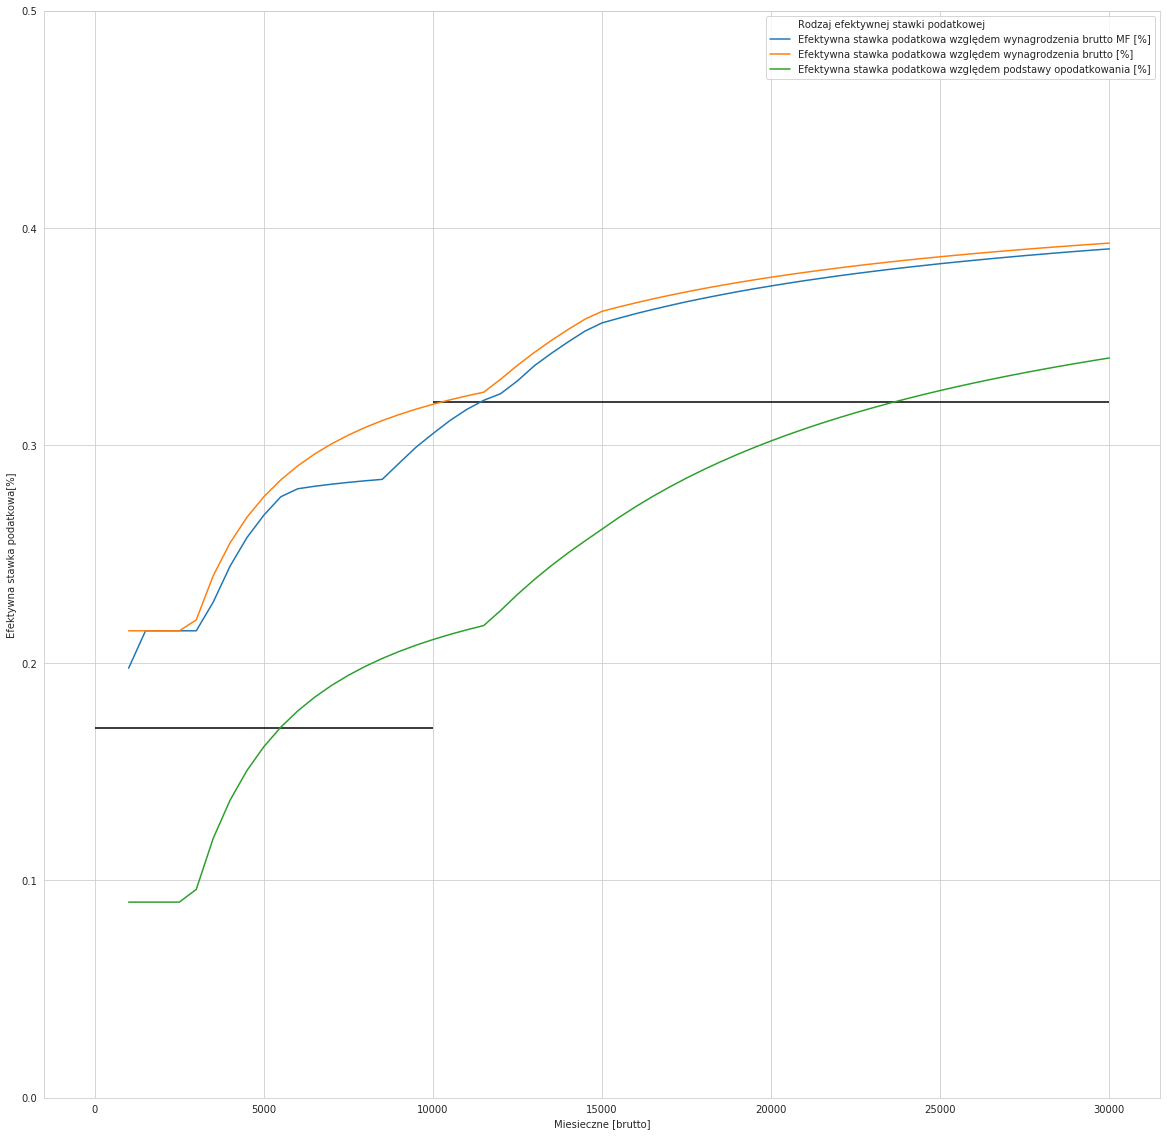

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 20)

sns.set_style("whitegrid")
df_wide = df.melt(
    id_vars=['Miesieczne [brutto]'],
    value_vars=[
        'Efektywna stawka podatkowa względem wynagrodzenia brutto MF [%]',
        'Efektywna stawka podatkowa względem wynagrodzenia brutto [%]',
        'Efektywna stawka podatkowa względem podstawy opodatkowania [%]'
    ],
    var_name='Rodzaj efektywnej stawki podatkowej',
    value_name='Efektywna stawka podatkowa[%]'
)

graph = sns.lineplot(
    x='Miesieczne [brutto]',
    y='Efektywna stawka podatkowa[%]',
    hue='Rodzaj efektywnej stawki podatkowej',
    data=df_wide
)

graph.set(ylim=[0, 0.5])
graph.hlines(0.17, 0, 10_000)
graph.hlines(0.32, 10_000, np.max(df['Miesieczne [brutto]']))